# Project 1: Natural Language Processing

Learning Objectives:
- Increase familiarity with pytorch
- Learn how to use an LSTM model
- Learn how to integrate Deep learning models
- Learn how to process/handle a new type of data
- Practice neural network optimization

Using pytorch, You will develop a POS tagger that uses both a bi-directional LSTM and a CNN for maximum accuracy. You can use the pytorch LSTM example and the CNN tutorial as a reference point. <br>
<br>
Required Structural Components: a word embedding, a CNN, a bi-directional LSTM, and linear layers.

## Code adapted from:
https://github.com/bentrevett/pytorch-pos-tagging/blob/master/1%20-%20BiLSTM%20for%20PoS%20Tagging.ipynb 

## Import packages

In [1]:
# pytorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# standard DS packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# natural language toolkit
import nltk

# use torchtext to create dataset
from torchtext.legacy import data
from torchtext.legacy import datasets

# to calculate training time
import time

## Exploratory data analysis

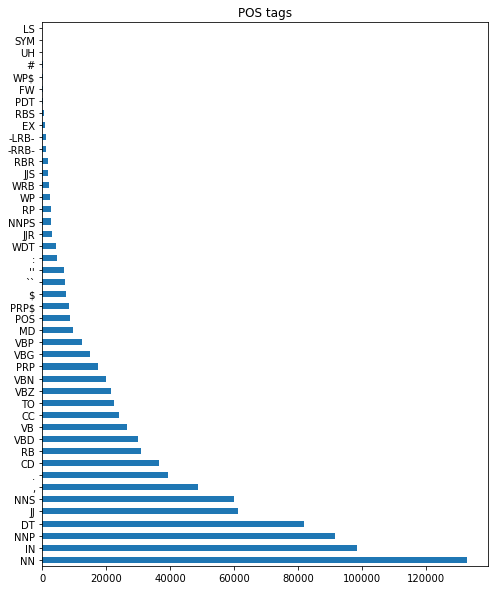

In [2]:
train_f = open("train.txt", "r") # open text file
train_words = train_f.read() # read every word
train_tagged = [nltk.tag.str2tuple(t) for t in train_words.split()] # split each word/POS tag into a tuple using nltk

# create dataframe and visualize POS tag counts
train_df = pd.DataFrame(train_tagged, columns = ['Word', 'Tag'])
# plot with matplotlib backend
train_df['Tag'].value_counts().plot(
    kind='barh', figsize=(8, 10), title='POS tags');

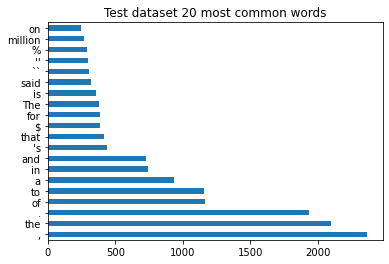

In [3]:
test_f = open("test.txt", "r") # open text file
test_words = test_f.read().split() # read every word and split at each word

# create dataframe and visualize word counts
test_df = pd.DataFrame(test_words, columns = ['Word'])
# plot with matplotlib backend
test_df['Word'].value_counts()[:20].plot(
    kind='barh', title='Test dataset 20 most common words');

## Prepare data

In [4]:
f = open("train.txt", "r") # open text file
lines = f.read().splitlines() # read line by line, each line is an item in a list
text = [sentence.split() for sentence in lines] # split each line into list of word/POS tag, result is list of lists

# split each word/POS tag into a tuple using nltk
tagged = []
for sentence in text:
    words = []
    for word in sentence:
        tags = nltk.tag.str2tuple(word)
        words.append(tags)
    tagged.append(words)

In [5]:
# the Torchtext Field specifies how the dataset is processed
# all text will be made lowercase
TEXT = data.Field(lower = True)
# TorchText Fields initialize a default unknown token, <unk>, which we remove by setting unk_token = None.
TAGS = data.Field(unk_token = None)

# create fields
fields = (('text', TEXT), ('tags', TAGS))

# create a torchtext dataset, i.e. a list of Examples
# each Example consists of a list of words in a sentence and the corresponding POS tags
examples = []
for sentence in tagged:
    text = []
    tags = []
    for word, tag in sentence:
        text.append(word)
        tags.append(tag)
    examples.append(data.Example.fromlist([text, tags], fields))
        
dset = data.Dataset(examples, fields)

# split data into train and validation
train_data, valid_data = dset.split(0.9)

In [6]:
print(len(train_data))
print(len(valid_data))

35849
3983


Building vocabulary is mapping each token to an integer, similar to word_to_ix in the provided example

In [7]:
# set the min_freq to 2 which means only tokens that appear twice in the training set 
# will be added to the vocabulary and the rest will be replaced by <unk> tokens
MIN_FREQ = 2

# use the GloVe pretrained 100 dimensional embeddings
# unk_init is used to initialize the token embeddings which are not in the pre-trained embedding vocabulary
# initialize them from a Normal/Gaussian distribution
TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)


# build mapping of tags to integers
TAGS.build_vocab(train_data)

In [8]:
BATCH_SIZE = 1

# place the batches on the GPU if there is one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data is iterated over to create batches of data to process
# batches should be shuffled between epochs, but the train-validation split remains the same
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.text), # have to provide a sorting function to the constructor of the BucketIterator
    sort_within_batch = False)

## Model
* **Embedding layer:** input dimension is size of vocabulary, embedding dimension is size of embeddings. We tell it what the index of the padding token is so it does not update the padding token's embedding entry.
* **CNN layer:** The CNN filters down the embeddings.
* **LSTM layer:** takes word embeddings as inputs, and outputs hidden states corresponding to each word. We specifiy the LSTM as bidirectional. We use dropout regularization between layers if there is more than one layer.
* **Linear layer:** maps from hidden state space to tag space. We double the size of the input because we are using a bi-directional LSTM.
* **Dropout layer:** In the forward method, we apply dropout to the embeddings and the outputs of the final layer of the LSTM.

In [10]:
class test_model(nn.Module):
    
    # constructor
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super(test_model, self).__init__()
        
        # embedding layer output shape (# of tokens in sentence, batch size, embedding dimension)
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        # convolution layer - You need to know # of channels/inputs and number of kernels (outputs)
        # output - (# of tokens in sentence, batch size, filtered embedding dimension)
        self.convolution = nn.Conv1d(in_channels = BATCH_SIZE, out_channels = BATCH_SIZE, kernel_size = 3)
        
        # 1-D max pooling
        # kernel_size is 2
        self.pool = nn.MaxPool1d(2)
        
        # relu activation function
        self.relu = nn.ReLU()
        
        # lstm layer - input_size = 23 after two convolutions (100 to 49 to 23)
        self.lstm = nn.LSTM(23, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = True,
                            dropout = dropout if n_layers > 1 else 0)
        
        # linear layer
        self.linear = nn.Linear(hidden_dim * 2, output_dim)
        
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        # pass text through embedding layer
        embedded = self.embedding(text)
        
        # first convolution with activation and pooling
        conv1 = self.pool(self.relu(self.convolution(embedded)))
        
        # second convolution with activation and pooling
        conv2 = self.pool(self.relu(self.convolution(conv1)))
        
        # pass embeddings into LSTM and output hidden states
        outputs, _ = self.lstm(conv2)
        
        # apply dropout to hidden state output and pass through linear layer
        # to make a prediction of what the tag should be
        predictions = self.linear(self.dropout(outputs))
        
        return predictions

Instantiate model with all the parameters

In [12]:
INPUT_DIM = len(TEXT.vocab) # vocab size
EMBEDDING_DIM = 100 # same as the GloVe pretrained embeddings
HIDDEN_DIM = 128 # arbitrary, can be changed
OUTPUT_DIM = len(TAGS.vocab) # tag size
N_LAYERS = 2 # number of layers in lstm
DROPOUT = 0.25 # arbitrary, can be changed
# get the index of the pad token created when we built the vocab
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# model = LSTMTagger(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX)
model = test_model(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX)

In [13]:
# initialize weights of parameters from a normal distribution
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

model.apply(init_weights) # apply to model

# initialize our model's embedding layer with the pre-trained GloVe embedding values we loaded earlier
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings) # apply to model

# initialize the embedding of the pad token to all zeros
# the embedding should always output a tensor full of zeros when a pad token is input
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train/ Validation

In [14]:
# define optimizer: Adam with default learning rate
optimizer = optim.Adam(model.parameters())

# define loss function: cross-entropy loss
# ignore index because we don't want to calculate the loss when the target is a <pad> token
TAG_PAD_IDX = TAGS.vocab.stoi[TAGS.pad_token]
loss_function = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

# place our model and loss function on our GPU, if we have one
model = model.to(device)
loss_function = loss_function.to(device)

In [15]:
# function to calculate accuracy after each epoch

def categorical_accuracy(preds, y, tag_pad_idx):
    # find the index where the probability is the greatest, that is your prediction
    max_preds = preds.argmax(dim = 1, keepdim = True)
    # get nonzero elements that aren't pad tokens
    non_pad_elements = (y != tag_pad_idx).nonzero()
    # .eq computes element-wise equality between our predictions and actual tags
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    # take the number of correct predictions and divide by the number of actual tags
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

In [16]:
def train(model, iterator, optimizer, loss_function, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # train mode
    model.train()
    
    for batch in iterator:
        
        # get text and tags for batch
        text = batch.text
        tags = batch.tags
        
        # Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        optimizer.zero_grad()
        
        # get predictions from model
        predictions = model(text)
        
        # get predictions and actual tags from objects
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        # apply loss function to predictions vs actual
        loss = loss_function(predictions, tags)
        # use accuracy function
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        # Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()       
        loss.backward()
        optimizer.step()
        
        # add loss and accuracy for epoch to list
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, loss_function, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # model.eval() is used to put the model in evaluation mode, 
    # so dropout/batch-norm/etc. are turned off
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            # get text and tags for batch
            text = batch.text
            tags = batch.tags
            
            # get predictions from model 
            predictions = model(text)
            
            # get predictions and actual tags from objects
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            # apply loss function to predictions vs actual
            loss = loss_function(predictions, tags)
            # use accuracy function
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            # add loss and accuracy for epoch to list
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
# function to get total epoch time
# subtracts start time from end time and converts into minutes / seconds

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Takes about 1.5 hours to train

In [19]:
N_EPOCHS = 5

# float('inf') is used for setting a variable with an infinitely large value
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    # get time at beginning of epoch
    start_time = time.time()
    
    # get loss and accuracy for train and validation
    train_loss, train_acc = train(model, train_iterator, optimizer, loss_function, TAG_PAD_IDX)
    valid_loss, valid_acc = evaluate(model, valid_iterator, loss_function, TAG_PAD_IDX)
    
    # get time at end of epoch
    end_time = time.time()

    # subtract start time from end time to get total epoch time
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # save only the best model (based on validation loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm_model.pt')
    
    # print output for epoch
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 18m 32s
	Train Loss: 0.323 | Train Acc: 90.22%
	 Val. Loss: 0.173 |  Val. Acc: 94.42%
Epoch: 02 | Epoch Time: 18m 39s
	Train Loss: 0.160 | Train Acc: 94.99%
	 Val. Loss: 0.154 |  Val. Acc: 95.01%
Epoch: 03 | Epoch Time: 18m 43s
	Train Loss: 0.138 | Train Acc: 95.63%
	 Val. Loss: 0.144 |  Val. Acc: 95.36%
Epoch: 04 | Epoch Time: 18m 46s
	Train Loss: 0.126 | Train Acc: 95.94%
	 Val. Loss: 0.142 |  Val. Acc: 95.45%
Epoch: 05 | Epoch Time: 18m 41s
	Train Loss: 0.118 | Train Acc: 96.19%
	 Val. Loss: 0.140 |  Val. Acc: 95.53%


## Test

In [20]:
# function to tag sentence in test data

def tag_sentence(model, device, sentence, text_field, tag_field):
    
    # put model in eval mode
    model.eval()
    
    # check if sentence is a list of words, else raise an error
    if isinstance(sentence, list):
        tokens = [token for token in sentence]
    else:
        raise TypeError("Only lists are allowed")
        
    # make all tokens lowercase if that's what the Field specifies
    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    # map integer value to the tokens
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]

    # get index of unknown token in text field
    unk_idx = text_field.vocab.stoi[text_field.unk_token]
    
    # get list of unknown tokens
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    # convert to long tensor
    token_tensor = torch.LongTensor(numericalized_tokens)
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    # put on GPU if one is present
    token_tensor = token_tensor.unsqueeze(-1).to(device)
        
    # feed the tensor into the model and make predictions on the text
    predictions = model(token_tensor)
    
    # get most likely prediction for each tag
    top_predictions = predictions.argmax(-1)
    
    # map the prediction to the corresponding tag
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    return tokens, predicted_tags, unks

In [21]:
# load test data

f = open("test.txt", "r") # open text file
lines = f.read().splitlines() # read line by line, each line is an item in a list
test_data = [sentence.split() for sentence in lines] # split each line into list of words, result is list of lists

In [22]:
model.load_state_dict(torch.load('lstm_model.pt')) # load model that was saved earlier
# device specified earlier
# text_field is TEXT
# tag_field is TAGS

# return tags for each word in test_data
test_tags = []
for sentence in test_data:
    tokens, predicted_tags, unks = tag_sentence(model, device, sentence, TEXT, TAGS)
    test_tags.append(predicted_tags)

In [23]:
# load example

EXAMPLE = 35

tokens = test_data[EXAMPLE]
tags = test_tags[EXAMPLE]

print("Pred. Tag\tToken\n")

for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")

Pred. Tag	Token

``		``
DT		The
NN		record
IN		of
NNS		companies
WDT		that
VBP		have
JJ		diversified
VBZ		is
RB		n't
DT		all
DT		that
JJ		impressive
,		,
''		''
PRP		he
VBZ		says
.		.


## Compare test_tags to the actual tags to get the accuracy of my model on the test dataset